
# Démo Unet



# Task 1 : Set up colab gpu runtime environment

In [36]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ydwpop4z
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ydwpop4z
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


We will use a Human Segmentation Dataset.
A dataset with 300 images of humans with some background and a corresponding binary mask for each of these images.


We will have two labels 0 and 1

*   0 for black region
*   1 for white region



In [37]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


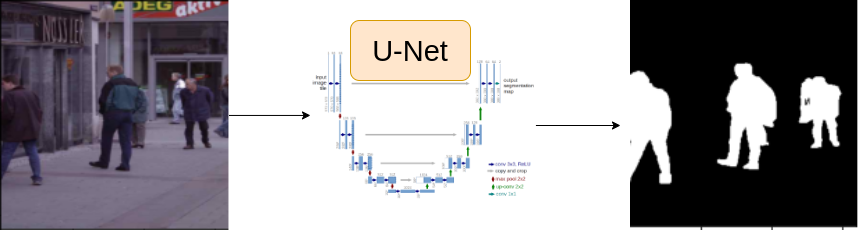

# Some Common Imports

In [38]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [39]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [40]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content'
DEVICE='cuda'
EPOCHS=40
LR=0.002
IMG_SIZE=320
BATCH_SIZE=16
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [41]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [42]:
df.iloc[0]['masks']
df.iloc[0]['images']

'Human-Segmentation-Dataset-master/Training_Images/1.jpg'

In [43]:
row=df.iloc[0]
image_path=row.images
mask_path=row.masks

In [44]:
mask_path

'Human-Segmentation-Dataset-master/Ground_Truth/1.png'

In [45]:
image=cv2.imread(image_path)
#open cv reads images in BGR format so we convert it to RGB format
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

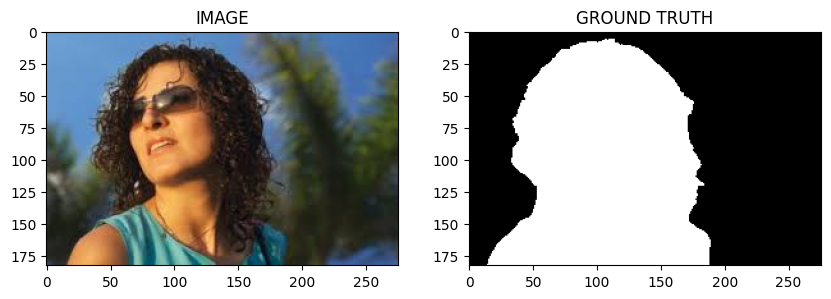

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [47]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

Augmentation task for the training set and the validation set.

in segmentation data set whenever some augmentation applies on the images its mask will have the same effect.

In [48]:
import albumentations as A

In [49]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [50]:
from torch.utils.data import Dataset

In [51]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) 
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)#dict format
      image=data['image']
      mask=data['mask']

      #(h,w,c) => (c,h,w)
      image=np.transpose(image,(2,0,1)).astype(np.float32)
      mask=np.transpose(mask,(2,0,1)).astype(np.float32)

      image=torch.Tensor(image) / 255.0
      mask=torch.round(torch.Tensor(mask) / 255.0)

      return image,mask

In [52]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [53]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [54]:
trainset

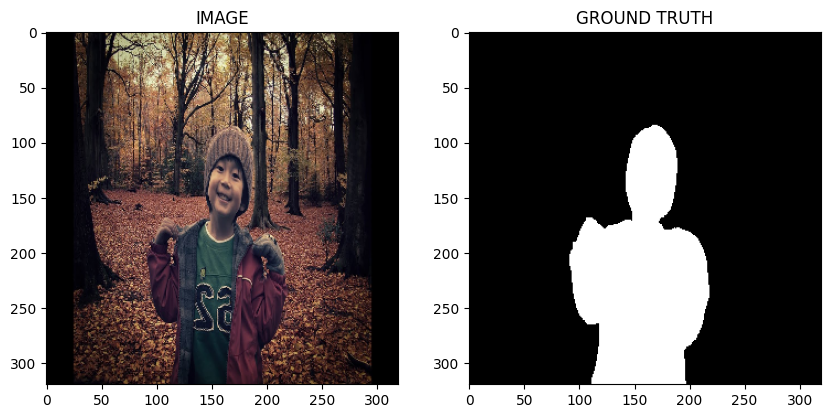

In [55]:
idx=21
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [56]:
from torch.utils.data import DataLoader

In [57]:
trainLoader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validLoader=DataLoader(validset,batch_size=BATCH_SIZE)

In [58]:
print(f"totat n of batches in trainLoader : {len(trainLoader)}")
print(f"totat n of batches in validLoader : {len(validLoader)}")

totat n of batches in trainLoader : 15
totat n of batches in validLoader : 4


In [59]:
for image,mask in trainLoader:
  break
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [60]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [61]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)
        loss = None
        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            loss = loss1 + loss2
        return logits,loss


In [62]:
model=SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [63]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward ()
    optimizer.step()
    total_loss += loss.item()
    
  return total_loss/len(data_loader)

In [64]:
def eval_fn(data_loader, model):
  model.eval ()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images,masks)
      total_loss += loss.item()
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [65]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [66]:
best_valid_loss=np.Inf

for i in range(EPOCHS) :
  train_loss=train_fn(trainLoader,model,optimizer)
  valid_loss=eval_fn(validLoader, model)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED_MODEL")
    best_valid_loss = valid_loss
  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


SAVED_MODEL
Epoch : 1 Train_loss : 0.7391727844874064 Valid_loss : 0.5987225025892258


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch : 2 Train_loss : 0.4102482000986735 Valid_loss : 1.2488698661327362


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


SAVED_MODEL
Epoch : 3 Train_loss : 0.34448351462682086 Valid_loss : 0.2949834205210209


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


SAVED_MODEL
Epoch : 4 Train_loss : 0.2682046055793762 Valid_loss : 0.29327020049095154


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


SAVED_MODEL
Epoch : 5 Train_loss : 0.24195562303066254 Valid_loss : 0.253083024173975


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 6 Train_loss : 0.20035423537095387 Valid_loss : 0.26182352378964424


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED_MODEL
Epoch : 7 Train_loss : 0.2104655921459198 Valid_loss : 0.23221300169825554


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


SAVED_MODEL
Epoch : 8 Train_loss : 0.19606823821862537 Valid_loss : 0.21200578287243843


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


Epoch : 9 Train_loss : 0.17565228839715322 Valid_loss : 0.21382640674710274


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


SAVED_MODEL
Epoch : 10 Train_loss : 0.14013768037160237 Valid_loss : 0.1930694431066513


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


SAVED_MODEL
Epoch : 11 Train_loss : 0.1336341455578804 Valid_loss : 0.17131123691797256


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch : 12 Train_loss : 0.12036084681749344 Valid_loss : 0.21423153951764107


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


SAVED_MODEL
Epoch : 13 Train_loss : 0.11301387796799342 Valid_loss : 0.1501892600208521


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch : 14 Train_loss : 0.09741840759913127 Valid_loss : 0.15038362331688404


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch : 15 Train_loss : 0.0837780808409055 Valid_loss : 0.1610591635107994


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 16 Train_loss : 0.08293567150831223 Valid_loss : 0.16852892376482487


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch : 17 Train_loss : 0.09543434878190359 Valid_loss : 0.15228324383497238


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch : 18 Train_loss : 0.08558881878852845 Valid_loss : 0.15891656652092934


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch : 19 Train_loss : 0.10145586381355921 Valid_loss : 0.1755677256733179


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch : 20 Train_loss : 0.0941442886988322 Valid_loss : 0.2304367795586586


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch : 21 Train_loss : 0.09203638931115468 Valid_loss : 0.20473146066069603


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch : 22 Train_loss : 0.10738740613063176 Valid_loss : 0.19431253150105476


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 23 Train_loss : 0.1035513386130333 Valid_loss : 0.1997634544968605


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch : 24 Train_loss : 0.1325966089963913 Valid_loss : 0.20789257809519768


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch : 25 Train_loss : 0.1366345797975858 Valid_loss : 0.2756648324429989


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 26 Train_loss : 0.15776304850975673 Valid_loss : 0.3163493536412716


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch : 27 Train_loss : 0.14833582788705826 Valid_loss : 0.26249975711107254


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 28 Train_loss : 0.13175591429074604 Valid_loss : 0.21122415363788605


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Epoch : 29 Train_loss : 0.10604722301165263 Valid_loss : 0.22494518756866455


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch : 30 Train_loss : 0.09667640626430511 Valid_loss : 0.20755451545119286


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 31 Train_loss : 0.08023026287555694 Valid_loss : 0.1661977730691433


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Epoch : 32 Train_loss : 0.09921256800492605 Valid_loss : 0.1960054636001587


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 33 Train_loss : 0.1765704224507014 Valid_loss : 0.33431315794587135


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 34 Train_loss : 0.13301918754975 Valid_loss : 0.19037976674735546


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch : 35 Train_loss : 0.11700284779071808 Valid_loss : 0.22763928771018982


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch : 36 Train_loss : 0.09137176970640819 Valid_loss : 0.18638981133699417


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch : 37 Train_loss : 0.08524804462989172 Valid_loss : 0.1652587093412876


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 38 Train_loss : 0.08659783154726028 Valid_loss : 0.16929423622787


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED_MODEL
Epoch : 39 Train_loss : 0.0793503167728583 Valid_loss : 0.13872111774981022


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

SAVED_MODEL
Epoch : 40 Train_loss : 0.0711153248945872 Valid_loss : 0.1349280457943678


# Task 9 : Inference

In [71]:
idx = 18

model.load_state_dict(torch.load("/content/best_model.pt"))

image,mask = validset[idx]

logits_mask =model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) => (1, C, H, W)

In [72]:
logits_mask

(tensor([[[[-3.6450, -5.0564, -5.3244,  ..., -5.3781, -4.7597, -2.6814],
           [-5.6365, -8.0160, -8.4561,  ..., -8.4092, -7.7788, -4.7679],
           [-6.0934, -8.8175, -9.5295,  ..., -8.7423, -8.1944, -5.2368],
           ...,
           [-0.4134,  0.4092,  1.0086,  ..., -7.5559, -7.0563, -4.6691],
           [-0.9832, -0.4881,  0.3092,  ..., -6.8963, -6.4988, -4.4123],
           [-0.9346, -0.7110, -0.1343,  ..., -5.1533, -4.7849, -3.2709]]]],
        device='cuda:0', grad_fn=<ConvolutionBackward0>),
 None)

In [73]:
pred_mask = torch.sigmoid(logits_mask[0])
pred_mask =(pred_mask > 0.5)*1.0

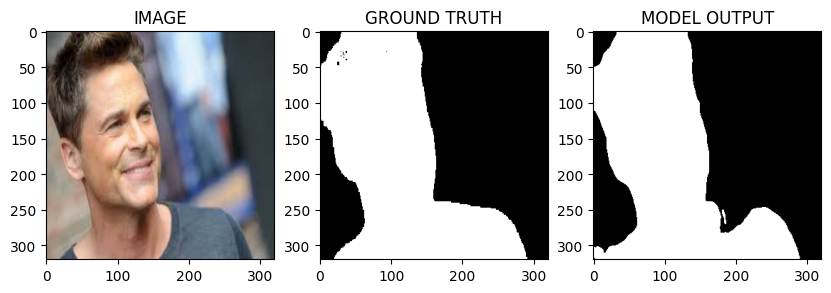

In [74]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))